# Libraries

In [1]:
import os
import cv2
import sys
import uuid
import joblib
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import concurrent.futures
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from concurrent.futures import ThreadPoolExecutor

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.svm import SVC
from sklearn.base import BaseEstimator
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

import xgboost as xgb

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [2]:
# Attaching project directory
sys.path.append(os.path.dirname(os.getcwd()))

# Pathing imports
from src import GetPath, FullMHI

In [3]:
# Normalize images
NORMALIZE = False

# Fixed randomness
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Model max iteration
MAX_ITERM = 1000

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
DATA_PATH = GetPath().shared_data()

REPO_PATH = GetPath().repo_data()

MHI_DATA = os.path.join(DATA_PATH, 'preprocess', 'mhi')

--- Defined Datapath 
D:/fish_behavior\data
--- Moving Project Path Upward
--- Defined Datapath 
c:\Users\admin\Desktop\Aquaculture-Intelligence\data


# Helper Function

In [5]:
class ClassificationModel:
    def __init__(self, model: BaseEstimator, model_name: str):
        self.model = model
        self.model_name = model_name
        self.is_trained = False

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        train_accuracy = self.model.score(X_train, y_train)
        print(f"{self.model_name} Training accuracy: {train_accuracy:.4f}")

    def evaluate(self, X_test, y_test):
        test_accuracy = self.model.score(X_test, y_test)
        y_pred = self.model.predict(X_test)

        print(f"{self.model_name} Test accuracy: {test_accuracy:.4f}")
        print("\n-----CLASSIFICATION REPORT-----\n")
        print(classification_report(y_test, y_pred))

        return y_test, y_pred

    def plot_confusion_matrix(self, y_true, y_pred):
        disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, xticks_rotation='vertical')
        disp.figure_.suptitle(f"{self.model_name} Confusion Matrix")
        plt.show()

    def run_full_analysis(self, X_train, y_train, X_test, y_test):
        self.train(X_train, y_train)
        y_true, y_pred = self.evaluate(X_test, y_test)
        self.plot_confusion_matrix(y_true, y_pred)

In [6]:
# Evaluate the performance of each base model
def train_and_evaluate(name, model, images_train, labels_train, images_test, labels_test):
    le = LabelEncoder()
    labels_train = le.fit_transform((labels_train))
    model.fit(images_train, labels_train)
    label_predict = model.predict(images_test)
    label_predict = le.inverse_transform(label_predict)
    accuracy = accuracy_score(labels_test, label_predict)
    f1 = f1_score(labels_test, label_predict, average='weighted', zero_division=0.0)
    precision = precision_score(labels_test, label_predict, average='weighted', zero_division=0.0)
    recall = recall_score(labels_test, label_predict, average='weighted', zero_division=0.0)
    return [name, accuracy, f1, precision, recall]

def model_selection(models, X_train, y_train, X_test, y_test):
    results = []
    with tqdm(total=len(models), desc='Model Training', unit='model') as progress:
        with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
            futures = []
            for name, model in models.items():
                future = executor.submit(
                    train_and_evaluate, 
                    name, 
                    model, 
                    X_train,
                    y_train,
                    X_test,
                    y_test
                )
                futures.append(future)

            for future in concurrent.futures.as_completed(futures):
                results.append(future.result())
                future.add_done_callback(lambda p: progress.update())
    
    return results

# Training with different time windows

In [7]:
# Getting different time windows
roots_dir = []
for file in os.listdir(MHI_DATA):
    file = os.path.join(MHI_DATA, file)
    if os.path.isdir(file):
        roots_dir.append(os.path.join(MHI_DATA, file))

In [8]:
# Define the base models
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=MAX_ITERM),
    'SGD Classifier': SGDClassifier(random_state=RANDOM_STATE),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'AdaBoost': AdaBoostClassifier(random_state=RANDOM_STATE, algorithm='SAMME'),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(random_state=RANDOM_STATE),
    'Gaussian Naive Bayes': GaussianNB(),
    'Multi-layer Perceptron': MLPClassifier(random_state=RANDOM_STATE, max_iter=MAX_ITERM),
    'XGBoost': xgb.XGBClassifier()
}

# Image transformation
train_transform = A.Compose([
        # Image resize
        A.Resize(32, 32),
        # Image normalize
        A.Normalize(mean=(0,0,0), std=(1,1,1),),
        # Random flip
        A.OneOf([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
        ], p=0.5),
        # Random rotate
        A.OneOf([
            A.RandomRotate90(),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
        ], p=0.5),
    ])

# Image transformation
test_transform = A.Compose([
        # Image resize
        A.Resize(32, 32),
        # Image normalize
        A.Normalize(mean=(0,0,0), std=(1,1,1),),
    ])

### Visualization of different size impact

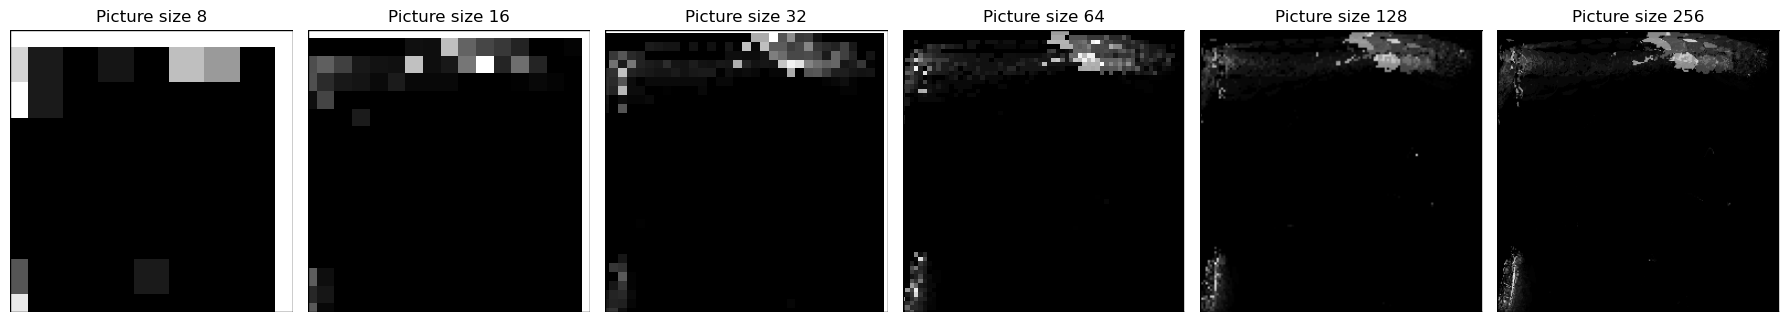

In [9]:
image_size = [8, 16, 32, 64, 128, 256]
images = []

for size in image_size:
    # Image transformation
    size_transform = A.Compose([
            # Image resize
            A.Resize(size, size),
            # Image normalize
            A.Normalize(mean=(0,0,0), std=(1,1,1),),
        ])
    
    datasets = FullMHI(root_dir=roots_dir[0], transform=size_transform)
    _, label, image = datasets.__getitem__(0)
    images.append(image)


# Calculate the number of rows and columns for the subplot grid
num_pictures = len(images)
num_cols = 6  # You can adjust this number to change the layout
num_rows = (num_pictures + num_cols - 1) // num_cols

# Create a figure and axis objects
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Plot each picture placeholder
for i, size in enumerate(image_size):
    width = size
    height = size
    
    ax = axes[i]
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    ax.set_aspect('equal')
    ax.add_patch(plt.Rectangle((0, 0), width, height, fill=False))
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f'Picture size {size}')
    ax.axis('off')

# Remove any unused subplots
for i in range(num_pictures, len(axes)):
    fig.delaxes(axes[i])

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

### Visualization of different time windows impact

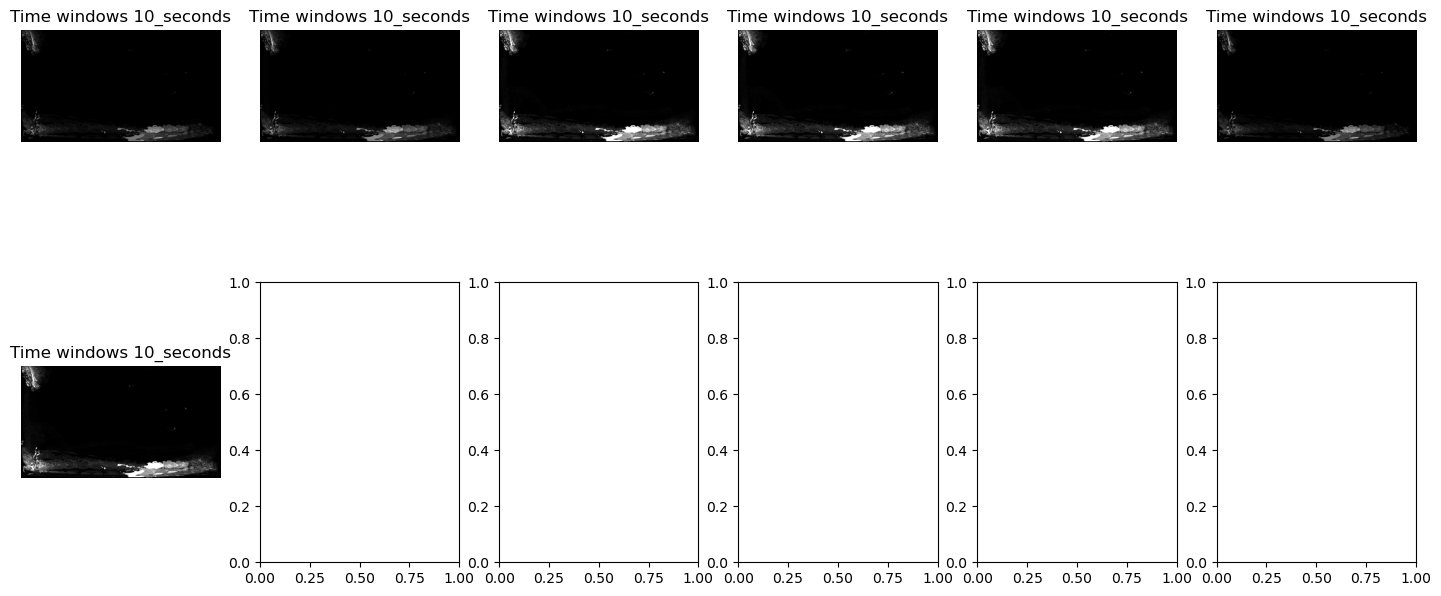

In [10]:
images = []

# Iterate through windows time (seconds)
for file in roots_dir:
    datasets = FullMHI(root_dir=file)
    _, label, image = datasets.__getitem__(0)
    images.append(image)

    
# Calculate the number of rows and columns for the subplot grid
num_pictures = len(images)
num_cols = 6  # You can adjust this number to change the layout
num_rows = (num_pictures + num_cols - 1) // num_cols

# Create a figure and axis objects
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Plot each picture placeholder
for i, time_window in enumerate(roots_dir):
    time_window = roots_dir[0].split("\\")[-1]
    ax = axes[i]
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f'Time windows {time_window}')
    ax.axis('off')

In [11]:
class Time_Windows_Selector:
    def __init__(self, 
                 model: BaseEstimator,
                 model_name: str, 
                 dataset_original: list, 
                 dataset_augmentated: list, 
                 n_augmentation: int, 
                 random_state: int,
                 result_path):
        
        self.model = model
        self.model_name = model_name
        self.dataset_original = dataset_original
        self.dataset_augmentated = dataset_augmentated
        self.n_augmentation = n_augmentation
        self.random_state = random_state
        self.result_path = result_path

        # Template
        self.idx_track = {
            'B1': [],
            'B2': [],
            'B3': []
        }

        self.labels_track = {
            'B1': [],
            'B2': [],
            'B3': []
        }

        # Assign tracker by experiments
        self.__get_tracks__()

        # Total dataset
        print(f"Total experiment dataset: {len(dataset_original)}")

    def __get_tracks__(self):
        # Assigning index tracker by batch experiment - training
        for idx in range(len(self.dataset_original)):
            experiment, label, image = self.dataset_original.__getitem__(idx)
            self.idx_track[experiment].append(idx)
            self.labels_track[experiment].append(label)

    def save_results(self, result: pd.DataFrame, fileName: str = "abnormal_multi_selection.csv"):
        file = os.path.join(self.result_path, fileName)

        if os.path.exists(file):
            results = pd.read_csv(file)
            results = pd.concat([results, result]).reset_index(drop=True)
            results.to_csv(file, index=False)

        if not os.path.exists(file):
            if not os.path.exists(self.result_path):
                os.makedirs(self.result_path)
                
            result.to_csv(file, index=False)
            

    def get_sets(self, idx_track: list, labels_track: list, validation_experiment: list):
        def get_image_label(idx, data):
            _, label, image = data.__getitem__(idx)
            return image.flatten(), label

        # Template
        X_train = []
        y_train = []
        X_test = []
        y_test = []
        X_val = []
        y_val = []

        # Train and test splitting between experiment B1 & B2, B1 does not have all abnormal level
        idx_train, idx_test = train_test_split(
            idx_track,
            test_size=0.3,
            random_state=self.random_state,
            stratify=labels_track
        )
            
        # Generate n times sample with different augmentation
        for i in range(self.n_augmentation):
            # for idx in idx_train:
            #     _, label, image = self.dataset_augmentated.__getitem__(idx)
            #     X_train.append(image.flatten())
            #     y_train.append(label)
            with ThreadPoolExecutor(max_workers=16) as executor:
                # Submitting get_image_label
                futures = [executor.submit(get_image_label, idx, self.dataset_augmentated) for idx in idx_train]

                # Collecting images and labels
                for future in futures:
                    X, y = future.result()
                    X_train.append(X)
                    y_train.append(y)
            
        # Message
        print(f"Total augmentated data for training: {len(X_train)}")

        # for idx in idx_test:
        #     _, label, image = self.dataset_original.__getitem__(idx)
        #     X_test.append(image.flatten())
        #     y_test.append(label)
        with ThreadPoolExecutor(max_workers=16) as executor:
            # Submitting get_image_label
            futures = [executor.submit(get_image_label, idx, self.dataset_original) for idx in idx_test]

            # Collecting images and labels
            for future in futures:
                X, y = future.result()
                X_test.append(X)
                y_test.append(y)        

        # for idx in validation_experiment:
        #     _, label, image = self.dataset_original.__getitem__(idx)
        #     X_val.append(image.flatten())
        #     y_val.append(label)
        with ThreadPoolExecutor(max_workers=16) as executor:
            # Submitting get_image_label
            futures = [executor.submit(get_image_label, idx, self.dataset_original) for idx in validation_experiment]

            # Collecting images and labels
            for future in futures:
                X, y = future.result()
                X_val.append(X)
                y_val.append(y)   
        
        return X_train, y_train, X_test, y_test, X_val, y_val


    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        train_accuracy = self.model.score(X_train, y_train)
        print(f"{self.model_name} Training accuracy: {train_accuracy:.4f}")

    def evaluate(self, X_test, y_test):
        # test_accuracy = self.model.score(X_test, y_test)
        y_pred = self.model.predict(X_test)

        # print(f"{self.model_name} Test accuracy: {test_accuracy:.4f}")
        print("\n-----CLASSIFICATION REPORT-----\n")
        print(classification_report(y_test, y_pred))

        return y_pred

    def plot_confusion_matrix(self, y_true, y_pred, model_name, batch, windows_time, img_size, save=False):
        if not model_name:
            model_name = self.model_name

        disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, xticks_rotation='vertical')
        disp.figure_.suptitle(f"{model_name} Confusion Matrix")

        if save:
            fileName = f'{model_name}_{batch}_{windows_time}_{img_size}.png'
            fileName = os.path.join(self.result_path, fileName)
            plt.savefig(fileName)
            
        plt.show()


    def macro_average_evaluation_matrix(self, y_true, y_pred, labels=None) -> pd.DataFrame:
        if isinstance(y_true, np.ndarray):
            y_true = np.array(y_true)

        if isinstance(y_pred, np.ndarray):
            y_pred = np.array(y_pred)

        # Get the classification report as a dictionary
        report = classification_report(y_true, y_pred, labels=labels, output_dict=True)
        
        # To dataframe only for macro average
        df = pd.DataFrame(report['macro avg'], index=[0])
        
        return df.rename(columns={
            'precision': 'precision_macro_avg',
            'recall': 'recall_macro_avg',
            'f1-score': 'f1_score_macro_avg',
            'support': 'support_macro_avg'
        })

    def run_full_analysis(self) -> pd.DataFrame:
        results = pd.DataFrame()
        for batch in ['B2', 'B3']:
            if batch == 'B2':
                validation_experiment = self.idx_track['B3']
            else:
                validation_experiment = self.idx_track['B2']

            X_train, y_train, X_test, y_test, X_val, y_val = self.get_sets(
                idx_track = self.idx_track['B1'] + self.idx_track[batch],
                labels_track = self.labels_track['B1'] + self.labels_track[batch],
                validation_experiment=validation_experiment
            )

            print(f"--- Conducting training with experiment B1 and {batch}")

            self.train(X_train, y_train)

            # Test
            print(f"Evaluation on test sets")
            yt_pred = self.evaluate(X_test, y_test)
            self.plot_confusion_matrix(y_test, yt_pred)

            # Validation
            print(f"Evaluation on validation sets")
            yv_pred = self.evaluate(X_val, y_val)
            self.plot_confusion_matrix(y_val, yv_pred)

            # Validation results
            result = self.macro_average_evaluation_matrix(y_val, yv_pred)
            result['training_batch'] = f'B1{batch}'
            results = pd.concat([results, result])

    def run_model_selection(self, models: dict, img_size: int, windows_time: int) -> pd.DataFrame:
        fileName = f'abnormal_multi_selection_{str(uuid.uuid4())}.csv'

        for batch in ['B2', 'B3']:

            if batch == 'B2':
                validation_experiment = self.idx_track['B3']
            else:
                validation_experiment = self.idx_track['B2']

            X_train, y_train, X_test, y_test, X_val, y_val = self.get_sets(
                idx_track = self.idx_track['B1'] + self.idx_track[batch],
                labels_track = self.labels_track['B1'] + self.labels_track[batch],
                validation_experiment=validation_experiment
            )

            for name, model in models.items():
                # Message
                print(f"--- Experimenting data on folder {file} with images size of {size}")
                print(f"--- Conducting training with experiment B1 and {batch} and {name} model")

                batch_name = f'B1{batch}'

                # Training
                model.fit(X_train, y_train)

                # Test
                print(f"Evaluation on test sets")
                yt_pred = model.predict(X_test)
                print(classification_report(y_test, yt_pred))
                self.plot_confusion_matrix(y_test, yt_pred, name, batch_name, windows_time, img_size)

                # Validation
                print(f"Evaluation on validation sets")
                yv_pred = model.predict(X_val)
                print(classification_report(y_val, yv_pred))
                self.plot_confusion_matrix(y_val, yv_pred, name, batch_name, windows_time, img_size, save=True)

                # Validation results
                result = self.macro_average_evaluation_matrix(y_val, yv_pred)


                result['training_batch'] = batch_name
                result['model'] = name
                result['img_size'] = img_size
                result['windows_time'] = windows_time

                result['accuracy'] = accuracy_score(y_val, yv_pred)
                result['recall_weighted'] = recall_score(y_val, yv_pred, average='weighted')
                result['precision_weighted'] = precision_score(y_val, yv_pred, average='weighted')
                result['f1_score_weighted'] = f1_score(y_val, yv_pred, average='weighted')
                
                self.save_results(result, fileName=fileName)



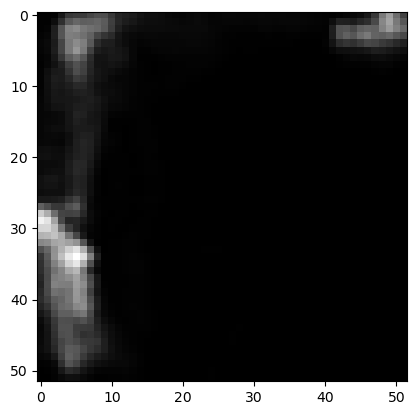

In [12]:
# Transformation Testing
size = 52
transform = A.Compose([
        # Image resize
        A.Resize(size, size),    
        A.SafeRotate(limit=45, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.5),
        A.RandomCrop(height=size, width=size, always_apply=False, p=0.5),
        A.PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0),
        A.Flip(p=0.5),
        A.Transpose(p=0.5),
        A.OneOf([
            A.MotionBlur(p=0.5),
            A.MedianBlur(p=0.5),
            A.GaussianBlur(p=0.5),
        ], p=0.5),
        A.OneOf([
            A.OpticalDistortion(border_mode=cv2.BORDER_CONSTANT, value=0, p=0.5),
            A.GridDistortion(border_mode=cv2.BORDER_CONSTANT, value=0, p=0.5),
            A.ElasticTransform(border_mode=cv2.BORDER_CONSTANT, value=0, p=0.5),
        ], p=0.5),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.5),
    ])

datasets = FullMHI(root_dir=file, transform=transform)
_, label, image = datasets.__getitem__(0)

plt.imshow(image, cmap='gray')

In [13]:
image_size = [8, 16, 32, 52, 64, 128, 224, 256]
results = pd.DataFrame()

# Image transformation
ToTrainTransform = A.Compose([
        # Image resize
        A.Resize(size, size),
        # Image normalize
        A.Normalize(mean=(0,0,0), std=(1,1,1),),
        # Random flip
        A.OneOf([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
        ], p=0.5),
        # Random rotate
        A.OneOf([
            A.RandomRotate90(),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
        ], p=0.5),
        # Brightness randomness
        A.RandomBrightnessContrast(p=0.5),
    ])

# Image transformation
ToTestTransform = A.Compose([
        # Image resize
        A.Resize(size, size),
        # Image normalize
        A.Normalize(mean=(0,0,0), std=(1,1,1),),
    ])


# for size in image_size:
#     # Iterate through windows time (seconds)
#     for file in roots_dir:
#         # Message
#         print(f"--- Experimenting data on folder {file} with images size of {size}")
#         # Loading datasets with augmentation
#         datasetsWithTransform = FullMHI(root_dir=file, transform=ToTrainTransform)
#         datasets = FullMHI(root_dir=file, transform=ToTestTransform)

#         selector = Time_Windows_Selector(
#             model=RandomForestClassifier(random_state=RANDOM_STATE),
#             model_name="Random Forest",
#             dataset_original=datasets,
#             dataset_augmentated=datasetsWithTransform,
#             n_augmentation=20,
#             random_state=RANDOM_STATE
#         )

#         result = selector.run_full_analysis()

#         result['img_size'] = size

#         # collector
#         results = pd.concat([results, result])

In [14]:
# Define the base models
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=MAX_ITERM),
    'SGD Classifier': SGDClassifier(random_state=RANDOM_STATE),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'AdaBoost': AdaBoostClassifier(random_state=RANDOM_STATE, algorithm='SAMME'),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(random_state=RANDOM_STATE),
    'Gaussian Naive Bayes': GaussianNB(),
    'Multi-layer Perceptron': MLPClassifier(random_state=RANDOM_STATE, max_iter=MAX_ITERM)
}

In [15]:
X_train = []
X_test = []
y_train = []
y_test = []
results = []

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=RANDOM_STATE)
csv_path = os.path.join(REPO_PATH, 'results', f'abn-multi-{str(uuid.uuid4())}.csv')
AUG_NUM = 2

for size in image_size:
    for file in roots_dir:
        db_aug = FullMHI(root_dir=file, transform=ToTrainTransform)
        db = FullMHI(root_dir=file, transform=ToTestTransform)

        # Get train
        for i in range(AUG_NUM):
            for idx in range(len(db)):
                experiment, label, image = db_aug.__getitem__(idx)

                if experiment == 'B1' or experiment == 'B3':
                    X_train.append(image.flatten())
                    y_train.append(label)

        # Get Test
        for idx in range(len(db)):
            experiment, label, image = db.__getitem__(idx)
            X_test.append(image.flatten())
            y_test.append(label)


        model = RandomForestClassifier(random_state=RANDOM_STATE)

        result = {
            'size': size,
            'window_size': os.path.basename(file)
        }

        for scoring in ['accuracy', 'precision_micro', 'recall_micro', 'f1_micro']:
            scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
            result[f'mean_{scoring}'] = np.mean(scores)

        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)

        disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical')
        titleName = f'{result["size"]}_{result["window_size"]}_CM'
        disp.figure_.suptitle(titleName)

        path_img = os.path.join(REPO_PATH, 'results', f'{titleName}.png')
        plt.savefig(path_img)
        plt.close()
        results.append(result)

        # saving
        pd.DataFrame(results).to_csv(csv_path)

# results = pd.DataFrame(results)
# csv_path = os.path.join(REPO_PATH, 'results', f'results-{str(uuid.uuid4())}.csv')
# results.to_csv(csv_path)

c:\Users\admin\anaconda3\envs\yolo8_env\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


In [ ]:
for size in image_size:
    # Iterate through windows time (seconds)
    for file in roots_dir:

        # Loading datasets with augmentation
        datasetsWithTransform = FullMHI(root_dir=file, transform=ToTrainTransform)
        datasets = FullMHI(root_dir=file, transform=ToTestTransform)

        # Initiate selector
        selector = Time_Windows_Selector(
            model=RandomForestClassifier(),
            model_name='Random Forest',
            dataset_original=datasets,
            dataset_augmentated=datasetsWithTransform,
            n_augmentation=20,
            random_state=RANDOM_STATE,
            result_path=os.path.join(REPO_PATH, 'results')
        )

        selector.run_model_selection(models, size, os.path.basename(file))

In [ ]:
for size in image_size:
    # Iterate through windows time (seconds)
    for file in roots_dir:

        # Loading datasets with augmentation
        datasetsWithTransform = FullMHI(root_dir=file, transform=ToTrainTransform)
        datasets = FullMHI(root_dir=file, transform=ToTestTransform)

        # Initiate selector
        selector = Time_Windows_Selector(
            model=xgb.XGBClassifier(),
            model_name='xgboost',
            dataset_original=datasets,
            dataset_augmentated=datasetsWithTransform,
            n_augmentation=20,
            random_state=RANDOM_STATE,
            result_path=os.path.join(REPO_PATH, 'results')
        )

        selector.run_model_selection(models, size, os.path.basename(file))

# HERE

In [ ]:
# Iterate through windows time (seconds)
for file in roots_dir:
    # Message
    print(f"Experimenting data on folder {file}")
    # Loading datasets with augmentation
    datasetsWithTransform = FullMHI(root_dir=file, transform=train_transform)
    datasets = FullMHI(root_dir=file, transform=test_transform)
    # Message
    print(f"Total experiment datasets: {len(datasets)}")

    # Assigning index tracker for each batch experiment
    idx_track = {
        'B1': [],
        'B2': [],
        'B3': []
    }

    labels_track = {
        'B1': [],
        'B2': [],
        'B3': []
    }

    # Reasign data
    for idx in range(len(datasets)):
        experiment, label, image = datasetsWithTransform.__getitem__(idx)
        idx_track[experiment].append(idx)
        labels_track[experiment].append(label)

    # Train and test splitting between experiment B1 & B2, B1 does not have all abnormal level
    idx_train, idx_test = train_test_split(
        idx_track['B1'] + idx_track['B2'],
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=labels_track['B1'] + labels_track['B2']
    )

    # Training variable
    X_train = []
    y_train = []

    # Generate n times sample with different augmentation
    for i in range(3):
        for idx in idx_train:
            experiment, label, image = datasetsWithTransform.__getitem__(idx)
            X_train.append(image.flatten())
            y_train.append(label)

    # Message
    print(f"Total augmentated data for training: {len(idx_train)}")

    # Test variable
    X_test = []
    y_test = []

    for idx in idx_test:
        experiment, label, image = datasets.__getitem__(idx)
        X_test.append(image.flatten())
        y_test.append(label)

    # Validation variable with experiment B3
    X_val = []
    y_val = []

    for idx in idx_track['B3']:
        experiment, label, image = datasets.__getitem__(idx)
        X_val.append(image.flatten())
        y_val.append(label)

    # run baseline selector
    results = model_selection(models, X_train, y_train, X_test, y_test)

    # Sort the results by F1-score in descending order
    results = sorted(results, key=lambda x: x[2], reverse=True)

    # Print the results
    print("Model Performance:")
    print("+-----------------------+----------+----------+----------+----------+")
    print("| Model                 | Accuracy | F1-score | Precision | Recall   |")
    print("+-----------------------+----------+----------+----------+----------+")
    for result in results:
        print("| {:<20} | {:.4f}   | {:.4f}   | {:.4f}   | {:.4f}   |".format(*result))
    print("+-----------------------+----------+----------+----------+----------+")

    # Choose the best model based on the results
    best_model = models[results[0][0]]
    print(f"The best model is {results[0][0]}")

    # Evaluation
    model = ClassificationModel(
        best_model,
        result[0][0]
    )

    X_train = []
    y_train = []
    for i in range(5):
        for idx in idx_train + idx_test:
            experiment, label, image = datasetsWithTransform.__getitem__(idx)
            X_train.append(image.flatten())
            y_train.append(label)

    model.run_full_analysis(
        X_train=X_train,
        X_test=X_val,
        y_train=y_train,
        y_test=y_val
    )

In [ ]:
# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.input_size = input_size

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(self.input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, self.input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
# Train Autoencoder
# Initialize the autoencoder
autoencoder_model = Autoencoder(input_size=32*32).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder_model.parameters())

# Training loop
num_epochs = 10

# Image transformation
autoencoder_transform = A.Compose([
        # Image resize
        A.Resize(32, 32),
        # Image normalize
        A.Normalize(mean=(0,0,0), std=(1,1,1),),
        ToTensorV2()
    ])

# Iterate through windows time (seconds)
for file in roots_dir:
    # Message
    print(f"Experimenting data on folder {file}")
    datasets = FullMHI(root_dir=file, transform=autoencoder_transform)
    train_loader = DataLoader(datasets, batch_size=128, shuffle=True)
    
    for epoch in range(num_epochs):
        for data in train_loader:
            _, _, img = data
            img = img.view(img.size(0), -1).to(device)

            # Forward pass
            output = autoencoder_model(img)
            loss = criterion(output, img)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training finished!")

In [ ]:
def encoder_image(image, input_size, model):
    model.eval()
    
    # Image to GPU
    image = torch.from_numpy(image)
    image = image.view(-1, input_size).to(device)

    with torch.no_grad():
        encoder_output = model.encoder(image)

    return encoder_output.cpu().numpy().flatten()

input_size = 32*32

In [ ]:
# Iterate through windows time (seconds)
for file in roots_dir:
    # Message
    print(f"Experimenting data on folder {file}")
    # Loading datasets with augmentation
    datasetsWithTransform = FullMHI(root_dir=file, transform=train_transform)
    datasets = FullMHI(root_dir=file, transform=test_transform)
    # Message
    print(f"Total experiment datasets: {len(datasets)}")

    # Assigning index tracker for each batch experiment
    idx_track = {
        'B1': [],
        'B2': [],
        'B3': []
    }

    labels_track = {
        'B1': [],
        'B2': [],
        'B3': []
    }

    # Reasign data
    for idx in range(len(datasets)):
        experiment, label, image = datasetsWithTransform.__getitem__(idx)
        idx_track[experiment].append(idx)
        labels_track[experiment].append(label)

    # Train and test splitting between experiment B1 & B2, B1 does not have all abnormal level
    idx_train, idx_test = train_test_split(
        idx_track['B1'] + idx_track['B2'],
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=labels_track['B1'] + labels_track['B2']
    )

    # Training variable
    X_train = []
    y_train = []

    # Generate n times sample with different augmentation
    for i in range(3):
        for idx in idx_train:
            experiment, label, image = datasetsWithTransform.__getitem__(idx)

            # feature extraction
            new_feature = encoder_image(image, input_size, autoencoder_model)

            # Extracted feature for training
            X_train.append(new_feature)
            y_train.append(label)

    # Message
    print(f"Total augmentated data for training: {len(idx_train)}")

    # Test variable
    X_test = []
    y_test = []

    for idx in idx_test:
        experiment, label, image = datasets.__getitem__(idx)

        # feature extraction
        new_feature = encoder_image(image, input_size, autoencoder_model)

        # Extracted feature for testing
        X_test.append(new_feature)
        y_test.append(label)

    # Validation variable with experiment B3
    X_val = []
    y_val = []

    for idx in idx_track['B3']:
        experiment, label, image = datasets.__getitem__(idx)

        # feature extraction
        new_feature = encoder_image(image, input_size, autoencoder_model)

        # Extracted feature for validation
        X_val.append(new_feature)
        y_val.append(label)

    # run baseline selector
    results = model_selection(models, X_train, y_train, X_test, y_test)

    # Sort the results by F1-score in descending order
    results = sorted(results, key=lambda x: x[2], reverse=True)

    # Print the results
    print("Model Performance:")
    print("+-----------------------+----------+----------+----------+----------+")
    print("| Model                 | Accuracy | F1-score | Precision | Recall   |")
    print("+-----------------------+----------+----------+----------+----------+")
    for result in results:
        print("| {:<20} | {:.4f}   | {:.4f}   | {:.4f}   | {:.4f}   |".format(*result))
    print("+-----------------------+----------+----------+----------+----------+")

    # Choose the best model based on the results
    best_model = models[results[0][0]]
    print(f"The best model is {results[0][0]}")

    # Evaluation
    model = ClassificationModel(
        best_model,
        result[0][0]
    )
    model.run_full_analysis(
        X_train=X_train+X_test,
        X_test=X_val,
        y_train=y_train+y_test,
        y_test=y_val
    )

In [ ]:
# Create feature names
feature_names = [f'feature_{i}' for i in range(X_train[0].shape[0])]

# Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'feature': [feature_names[i] for i in indices],
    'importance': importances[indices]
})

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train[0].shape[0]), importances[indices])
plt.xticks(range(X_train[0].shape[0]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Print feature importances
print(feature_importance_df)

In [ ]:
# Train Autoencoder
# Initialize the autoencoder
autoencoder_model = Autoencoder(input_size=32*32).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder_model.parameters())

# Training loop
num_epochs = 10

# Image transformation
autoencoder_transform = A.Compose([
        # Image resize
        A.Resize(32, 32),
        # Image normalize
        A.Normalize(mean=(0,0,0), std=(1,1,1),),
        ToTensorV2()
    ])

# Iterate through windows time (seconds)
for file in roots_dir:
    # Message
    print(f"Experimenting data on folder {file}")
    datasets = FullMHI(root_dir=file, transform=autoencoder_transform)
    train_loader = DataLoader(datasets, batch_size=128, shuffle=True)
    
    for epoch in range(num_epochs):
        for data in train_loader:
            _, _, img = data
            img = img.view(img.size(0), -1).to(device)

            # Forward pass
            output = autoencoder_model(img)
            loss = criterion(output, img)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Loading datasets with augmentation
    datasetsWithTransform = FullMHI(root_dir=file, transform=train_transform)
    datasets = FullMHI(root_dir=file, transform=test_transform)
    # Message
    print(f"Total experiment datasets: {len(datasets)}")


    # Assigning index tracker for each batch experiment
    idx_track = {
        'B1': [],
        'B2': [],
        'B3': []
    }

    labels_track = {
        'B1': [],
        'B2': [],
        'B3': []
    }

    # Reasign data
    for idx in range(len(datasets)):
        experiment, label, image = datasetsWithTransform.__getitem__(idx)
        idx_track[experiment].append(idx)
        labels_track[experiment].append(label)

    # Train and test splitting between experiment B1 & B2, B1 does not have all abnormal level
    idx_train, idx_test = train_test_split(
        idx_track['B1'] + idx_track['B2'],
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=labels_track['B1'] + labels_track['B2']
    )

    # Training variable
    X_train = []
    y_train = []

    # Generate n times sample with different augmentation
    for i in range(3):
        for idx in idx_train:
            experiment, label, image = datasetsWithTransform.__getitem__(idx)

            # feature extraction
            new_feature = encoder_image(image, input_size, autoencoder_model)

            # Extracted feature for training
            X_train.append(new_feature)
            y_train.append(label)

    # Message
    print(f"Total augmentated data for training: {len(idx_train)}")

    # Test variable
    X_test = []
    y_test = []

    for idx in idx_test:
        experiment, label, image = datasets.__getitem__(idx)

        # feature extraction
        new_feature = encoder_image(image, input_size, autoencoder_model)

        # Extracted feature for testing
        X_test.append(new_feature)
        y_test.append(label)

    # Validation variable with experiment B3
    X_val = []
    y_val = []

    for idx in idx_track['B3']:
        experiment, label, image = datasets.__getitem__(idx)

        # feature extraction
        new_feature = encoder_image(image, input_size, autoencoder_model)

        # Extracted feature for validation
        X_val.append(new_feature)
        y_val.append(label)

    # run baseline selector
    results = model_selection(models, X_train, y_train, X_test, y_test)

    # Sort the results by F1-score in descending order
    results = sorted(results, key=lambda x: x[2], reverse=True)

    # Print the results
    print("Model Performance:")
    print("+-----------------------+----------+----------+----------+----------+")
    print("| Model                 | Accuracy | F1-score | Precision | Recall   |")
    print("+-----------------------+----------+----------+----------+----------+")
    for result in results:
        print("| {:<20} | {:.4f}   | {:.4f}   | {:.4f}   | {:.4f}   |".format(*result))
    print("+-----------------------+----------+----------+----------+----------+")

    # Choose the best model based on the results
    best_model = models[results[0][0]]
    print(f"The best model is {results[0][0]}")

    # Evaluation
    model = ClassificationModel(
        best_model,
        result[0][0]
    )
    model.run_full_analysis(
        X_train=X_train+X_test,
        X_test=X_val,
        y_train=y_train+y_test,
        y_test=y_val
    )

In [ ]:
# Create feature names
feature_names = [f'feature_{i}' for i in range(X_val[0].shape[0])]

df_ae = pd.concat([
    pd.DataFrame(X_val, columns=feature_names), 
    pd.DataFrame(y_val, columns=['label'])],
    axis=1)
df_ae

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_compress(data, explained_variance_threshold=0.95):
    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    # Perform PCA with full number of components
    pca = PCA()
    pca.fit(data_scaled)
    
    # Find the optimal number of components
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance_ratio >= explained_variance_threshold) + 1
    
    # Perform PCA with the optimal number of components
    pca = PCA(n_components=n_components)
    compressed_data = pca.fit_transform(data_scaled)
    
    # Calculate compression ratio
    original_size = data.shape[1]
    compressed_size = compressed_data.shape[1]
    compression_ratio = 1 - (compressed_size / original_size)
    
    # Calculate explained variance ratio
    explained_variance_ratio = np.sum(pca.explained_variance_ratio_)
    
    return compressed_data, compression_ratio, explained_variance_ratio, n_components

# Compress the data
compressed_data, compression_ratio, explained_variance_ratio, n_components = pca_compress(df_ae.iloc[:, :-1])

print(f"Original data shape: {data.shape}")
print(f"Compressed data shape: {compressed_data.shape}")
print(f"Optimal number of components: {n_components}")
print(f"Compression ratio: {compression_ratio:.2f}")
print(f"Explained variance ratio: {explained_variance_ratio:.2f}")

In [ ]:
dfc = pd.concat([
    pd.DataFrame(compressed_data, columns=['feature_1', 'feature_2']),
    pd.DataFrame(y_val, columns=['label'])
], axis=1)

sns.scatterplot(dfc, x='feature_1', y='feature_2', hue='label')